# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали ранее.

Нужно построить модель с максимально большим значением accuracy, для этого нужно довести долю правильных ответов по крайней мере до 0.75. Проверить accuracy на тестовой выборке.

## Этапы выполнения

1. Импорт библиотек, данных из файла, изучение датафрейма;
2. Разделение исходных данных на выборки: 1) обучающую, 2) валидационную и 3) тестовую;
3. Исследование качества разных моделей, при разных гиперпараметрах;
4. Проверка качества модели на тестовой выборке;
5. Проверка модели на вменяемость.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- **сalls** — количество звонков,
- **minutes** — суммарная длительность звонков в минутах,
- **messages** — количество sms-сообщений,
- **mb_used** — израсходованный интернет-трафик в Мб,
- **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

# Изучение входных данных


## Импорт библиотек и данных

In [1]:
# импорт необходимых библиотеки и модулей в проекте
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

import time

In [2]:
# откроем датафрейм (try - локально, except - по ссылке), посмотрим на содержимое
try:
    df = pd.read_csv('data/users_behavior.csv')
    
except:
    df = pd.read_csv('ССЫЛКА НА САЙТ С ДАННЫМИ')

df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


## Общая информация о датафрейме

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В датафрейме есть две колонки, содержимое которых может быть только целым числом, это **сalls** — количество звонков и **messages** — количество sms-сообщений. Заменим сразу тип данных на тип **int**. В остальном, предобработка данных не нужна.

In [4]:
df[['calls', 'messages']] = df[['calls', 'messages']].astype(int)

Пропуски в столбцах:

In [5]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Общая гистограмма для всех числовых столбцов датафрейма

<function matplotlib.pyplot.show(close=None, block=None)>

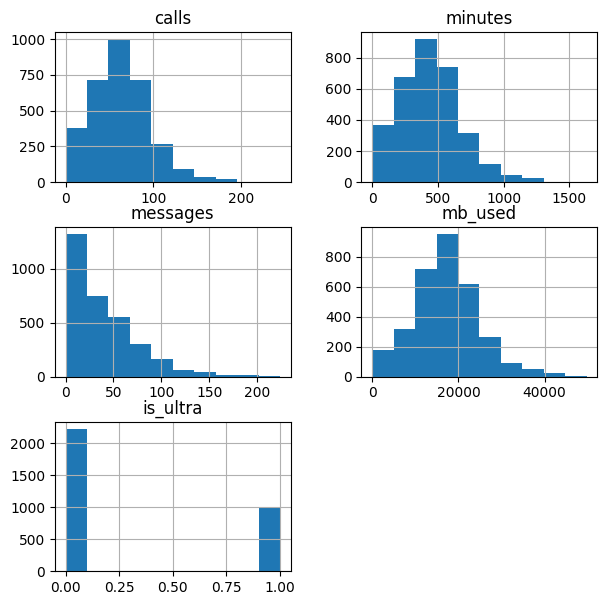

In [6]:
# построим общую гистограмму 
df.hist(figsize=(7, 7))
plt.show

По общей гистограмме:
- **сalls** — график количества звонков имеет нормальное распределение Гаусса
- **minutes** — график суммарной длительности звонков в минутах имеет нормальное распределение Гаусса
- **messages** — количество sms-сообщений имеет нисходящий тренд
- **mb_used** — график израсходованного интернет-трафика имеет нормальное распределение Гаусса
- **is_ultra** — на графике тарифа использования в течение месяца («Ультра» — 1, «Смарт» — 0) очевидно двукратное преобладание тарифа "Смарт"

Основные статистические данные датафрейма

In [7]:
np.round(df.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.04,33.24,0.0,40.00,62.00,82.00,244.00
minutes,3214.0,438.21,234.57,0.0,274.58,430.60,571.93,1632.06
messages,3214.0,38.28,36.15,0.0,9.00,30.00,57.00,224.00
mb_used,3214.0,17207.67,7570.97,0.0,12491.90,16943.24,21424.70,49745.73
is_ultra,3214.0,0.31,0.46,0.0,0.00,0.00,1.00,1.00


Предобработка данных не понадобится — её уже сделали в проекте курса «Статистический анализ данных»

<AxesSubplot:>

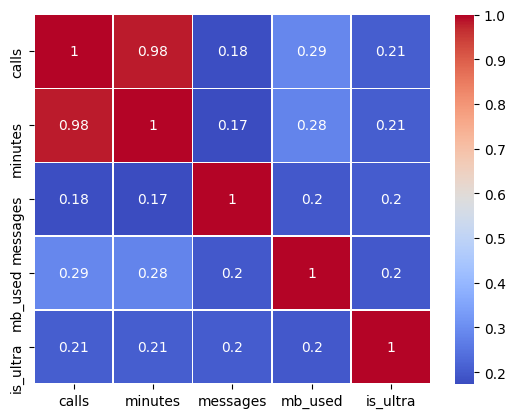

In [8]:
sns.heatmap(df.corr(),annot=True, linewidth=.5, cmap='coolwarm')

<div style='border:solid blue 3px; padding: 20px'>

**Выводы п.2:**
- Объем данных маленький, всего 126 кб
- Количество строк в ДФ: 3214
- В двух колонках (**сalls и messages**) тип данных заменен на **int**
- Предобработка данных не потребовалась
- На матрице выше наблюдается сильная корреляции между минутами и количеством звонков

# Немного теории

У нас есть обучающий набор данных и целевой признак, который нужно предсказать по остальным признакам, — **выбор тарифа**. Такие задачи относятся к классу «обучение с учителем» (от англ. supervised learning). «Учитель» ставит вопросы (признаки) и указывает ответы (целевой признак). Целевой признак у нас категориальный (выбор тарифа), значит решается задача **классификации**.

Чтобы делать предсказания, нужно понимать взаимосвязи признаков и ответов, для этого нужно обучить модель. После обучения модель готова предсказывать: получать на вход новые объекты (признаки) и выдавать ответы (целевой признак).

Существует множество **моделей классификации** в машинном обучении, включая:

1. Логистическая регрессия
2. Метод опорных векторов (SVM)
3. Решающие деревья и их ансамбли (случайный лес, градиентный бустинг)
4. Нейронные сети (глубокое обучение)
5. Наивный Байесовский классификатор
6. К-ближайших соседей (KNN)
7. Методы кластеризации (к-средних, иерархическая кластеризация)

Каждая модель имеет свои преимущества и недостатки, а также подходит для разных типов данных и задач классификации.

Далее рассмотрим модели нашего проекта.

**DecisionTreeClassifier** — это структура данных для классификации деревом решений. Анализ дерева классификации - когда предсказываемый выход является классом, которому данные принадлежат. **Дерево решений** — один из наиболее часто и широко используемых алгоритмов машинного обучения с учителем, который может выполнять как задачи регрессии, так и задачи классификации. Оно может описывать процесс принятия решения на основе значений признаков формулируются ответы, а затем выстраивается дерево с ответами «Да»/«Нет» и различными вариантами действий.

**RandomForestClassifier** Классификация подойдёт к концу, когда сеть дойдёт до подмножества только с одним объектом. Если объединить несколько подобных деревьев решений, то получится так называемый Случайный Лес (англ. Random Forest). Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения.

**Logistic Regression** Логистическая регрессия выводит прогнозы о точках в бинарном масштабе — нулевом или единичном. Если значение чего-либо равно либо больше 0.5, то объект классифицируется в большую сторону (к единице). Если значение меньше 0.5 — в меньшую (к нулю). У каждого признака есть своя метка, равная только 0 или только 1. Логистическая регрессия является линейным классификатором и поэтому используется, когда в данных прослеживается какая-то линейная зависимость.

Чтобы модели лучше замечали в данных зависимости, во многие алгоритмы машинного обучения добавляется случайность.
По-настоящему случайные числа компьютер не создаёт. Он подключает генераторы псевдослучайных чисел, которые производят последовательности, похожие на случайные. Псевдослучайность для алгоритма обучения создается указанием параметра **random_state=12345**.

Оценивают качество работы и выражаются в числовой форме **Метрики качества:**

- **accuracy** - это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству
- **precision** (точность) представляет собой отношение числа семплов, верно классифицированных как Positive, к общему числу выборок с меткой Positive (распознанных правильно и неправильно). Precision измеряет точность модели при определении класса Positive.
- **recall** (полнота) рассчитывается как отношение числа Positive выборок, корректно классифицированных как Positive, к общему количеству Positive семплов. Recall измеряет способность модели обнаруживать выборки, относящиеся к классу Positive. Чем выше recall, тем больше Positive семплов было найдено.

Метрики качества тесно связаны с исходной задачей классификации. Каждое неправильное предсказание — это неверная подсказка и потенциальная упущенная выгода для продавца. И наоборот: чем выше точность классификации, тем больше прибыли принесёт продукт.

Отношение числа правильных ответов к размеру тестовой выборки называется **accuracy** (англ. «правильность»), или «доля правильных ответов».

Если **accuracy** на тестовой выборке модели ниже, чем на обучающей, то столкнулись с проблемой **переобучения**. Обратный эффект — **недообучение**. Оно возникает, когда качество на обучающей и тестовой выборках примерно одинаковое, причём низкое.

Чтобы оценка качества была более надёжной, нужно подготовить новую выборку — валидационную (англ. validation, «проверка»), или проверочную. Валидационная выборка отбирается из исходного датасета ещё до обучения модели. Именно валидация подсказывает, как ведёт себя модель в полевых условиях и нет ли переобучения.

**Гиперпараметры**. Правильность предсказания решающего дерева определяет количество узлов и их взаимное расположение (структура), вопрос в вершине и ответы в нижних узлах. Всё это параметры, которые модель узнаёт из обучающих данных. Помимо обычных параметров, есть ещё **гиперпараметры**, настройки алгоритмов обучения. В **решающем дереве** - это максимальная глубина или выбор критерия — **Джини**.

Гиперпараметры помогают улучшить модель:
- **criterion='gini' — критерий Джини**, который показывает меру сходства двух наборов данных. Обучаясь, дерево в каждом узле (на каждой развилке) из возможных вопросов задаёт наилучший. Сейчас оно выбирает тот вопрос, для которого критерий Джини показывает, что отнесённые к левой ветке данные меньше всего похожи на те, что в правой.
- **min_samples_split** (от англ. «минимальное количество примеров для разделения»). Этот гиперпараметр запрещает создавать узлы, в которые попадает слишком мало объектов обучающей выборки.
- **min_samples_leaf** (от англ. «минимальное количество объектов в листе»). Листья — это нижние узлы с ответами. А гиперпараметр не разрешает создавать лист, в котором слишком мало объектов обучающей выборки.


Самый важный гиперпараметр решающего дерева — **max_depth**. Именно он определяет, что в итоге получим — пень с одним вопросом или клён с ветвистой кроной. Для выбора этого параметра в цикле нужно перебрать разные значения и сравнить качество моделей в разных вариантах.

Для выбора модели обучения есть два основных критерия:

1. **Качество (accuracy)**. Это самый важный критерий для бизнеса: чем выше качество, тем больше прибыли приносит продукт. Самое высокое качество у случайного леса: вместо одного решающего дерева используется целый ансамбль. На втором месте — логистическая регрессия. Модель несложная, а значит, переобучение ей не грозит. Самое низкое качество предсказания у дерева решений. Если глубина меньше четырёх, оно недообучается, когда больше — переобучается.

2. **Скорость работы**. Не менее значимый критерий: если сервис работает медленно, оттока пользователей не избежать. Высокая скорость работы у логистической регрессии: у неё меньше всего параметров. Скорость решающего дерева тоже высокая и зависит от глубины. Случайный лес медленнее всех: чем больше деревьев, тем неторопливее работает модель.


Наиболее распространённая метрика качества в задаче регрессии — **средняя квадратичная ошибка, MSE** (от англ. Mean Squared Error). Ошибка объекта показывает, как сильно правильный ответ отличается от предсказания. Если ошибка намного больше нуля, модель квартиру переоценила; меньше — недооценила. Возведение в квадрат убирает разницу между переоценкой и недооценкой. Без этого шага нет смысла суммировать ошибки: положительные будут компенсировать отрицательные. Усреднение нужно, чтобы получить данные по всем объектам. Величина **MSE**, должна быть **как можно меньше**.




**Мультиколлинеарность** - это явление, когда два или более признаков в модели сильно коррелируют друг с другом. Такое явление может приводить к проблемам при анализе данных и построении моделей.

**Два типа проблем**, которые могут возникнуть из-за мультиколлинеарности:

1. **Неустойчивость коэффициентов регрессии:** мультиколлинеарность может привести к тому, что коэффициенты регрессии становятся неустойчивыми и не могут быть оценены точно.

2. **Плохая интерпретация:** мультиколлинеарность может привести к тому, что интерпретация эффектов отдельных признаков становится затруднительной.

Мультиколлинеарность может быть проблемой для моделей линейной регрессии, логистической регрессии и других моделей, которые используют линейные комбинации признаков.

**Варианты решения проблемы мультиколлинеарности:**

1. Удаление одного или нескольких коррелирующих признаков из модели.

2. Использование методов регуляризации, таких как L1 или L2 регуляризация, которые штрафуют модель за использование большого количества признаков.

3. Использование методов главных компонент (PCA), которые позволяют снизить размерность данных и устранить мультиколлинеарность.

4. Использование других моделей, которые не используют линейные комбинации признаков, например, деревья решений или случайный лес.

# Разбивка данных на выборки

**ТЕОРИЯ**

Целевой признак у нас категориальный (выбор тарифа), то решается задача классификации. Когда категорий всего две (тариф Ультра, иои Смарт) — речь идёт о бинарной (двоичной) классификации.

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: **обучающую, валидационную и тестовую**. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.

**Обучающая** выборка используется для обучения модели, **тестовая** - для проверки точности предсказаний на новых данных, а **валидационная** - для настройки параметров модели и предотвращения переобучения. Обычно обучающая выборка занимает 60-80% от всей выборки, тестовая - 20-30%, а валидационная - 10-20%. При этом, если данные небольшие, то можно использовать **кросс-валидацию**, когда выборка разбивается на несколько частей, и каждая из них по очереди используется для тестирования и валидации модели. **Валидационная** выборка нужна для оптимизации гиперпараметров модели и контроля за переобучением. Она помогает выбирать лучшие значения гиперпараметров и настраивать модель таким образом, чтобы она не переобучалась на обучающих данных.

Существует несколько способов разделения исходных данных на обучающую, валидационную и тестовую выборки:

1. Случайное разбиение: данные случайным образом делятся на три выборки в заданных пропорциях. Например, 60% для обучения, 20% для валидации и 20% для тестирования.

2. Стратифицированное разбиение: данные разделяются на выборки с сохранением пропорций по классам или другим категориальным признакам. Это позволяет избежать смещения выборок и улучшить качество модели.

3. Последовательное разбиение: данные разделяются на выборки последовательно, например, сначала на обучающую и оставшиеся на тестовую, а затем тестовая выборка делится на валидационную и тестовую.

Рассмотрим колонку **is_ultra**, где «Ультра» — 1, «Смарт» — 0. Посчитаем количество каждого значения

In [9]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Нужно построить модель для задачи классификации, которая выберет подходящий тариф.
Разобьем данные случайным образом на train, valid и test в процентном соотношении 60-20-20%:

In [10]:
# создание переменной для признаков
features = df.drop(['is_ultra'], axis=1) # извлекаем признаки

# создание переменной для целевого признака
target = df['is_ultra']

# разделяем данные на обучающую и валидационную выборки в соотношении 60/40 (обучающая/валидационная)
features_train, features_valid, target_train, target_valid, = train_test_split(
    features, target, test_size=0.40, random_state=12345)

# разделяем поровну (по 50% от 40% оставшихся данных, или по 20% от исходных) валидационную и тестовую выборку
features_valid, features_test, target_valid,target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)# 

In [11]:
print("Обучающая выборка:", features_train.shape)
print("Тестовая выборка:", features_test.shape)
print("Валидационная выборка:", features_valid.shape)

Обучающая выборка: (1928, 4)
Тестовая выборка: (643, 4)
Валидационная выборка: (643, 4)


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.4:**
- сделана разбивка данных на train, valid и test в процентном соотношении 60-20-20%
- по рекомендации коллег есть еще способ разбивки данных описанный на stackoverflow, а также библиотекой **fast_ml**

https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213

# Исследование моделей

**ЗАДАЧА:** исследовать качество разных моделей, меняя гиперпараметры

## DecisionTreeClassifier

**ТЕОРИЯ**

**DecisionTreeClassifier** — это структура данных для классификации деревом решений. Анализ дерева классификации - когда предсказываемый выход является классом, которому данные принадлежат. **Дерево решений** — один из наиболее часто и широко используемых алгоритмов машинного обучения с учителем, который может выполнять как задачи регрессии, так и задачи классификации. Оно может описывать процесс принятия решения на основе значений признаков формулируются ответы, а затем выстраивается дерево с ответами «Да»/«Нет» и различными вариантами действий.

Для данной модели есть следующие гиперпараметры:
- max_depth (максимальная глубина дерева),
- min_samples_split (минимальное количество объектов в узле для разделения),
- min_samples_leaf (минимальное количество объектов в листе),
- max_features (максимальное количество признаков для разделения узла).

Best accuracy: 0.7853810264385692
Best max depth: 3
Best model: DecisionTreeClassifier(max_depth=3)
Время работы модели: 0.3270747661590576


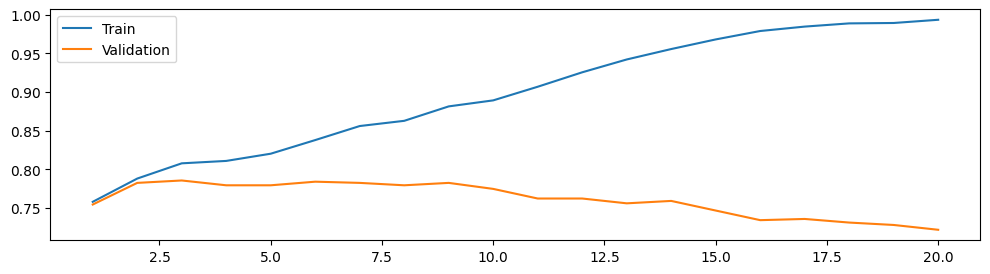

CPU times: total: 516 ms
Wall time: 515 ms


In [12]:
%%time
# вкл счетчик времени расчета модели
start = time.time()


# Создание списка значений max_depth для перебора
max_depth_values = range(1, 21)

# Создание списков для хранения метрик accuracy
accuracy_list_train = []
accuracy_list_valid = []

# Перебор значений в max_depth_values и обучение моделей
for depth in max_depth_values:
    # Создание модели
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    # Оценка точности на обучающей выборке
    model.fit(features_train, target_train)
    accuracy_train = model.score(features_train, target_train)
    accuracy_list_train.append(accuracy_train)
    
    # Оценка точности на валидационной выборке
    model.fit(features_train, target_train)
    accuracy_valid = model.score(features_valid, target_valid)
    accuracy_list_valid.append(accuracy_valid)

# Нахождение модели с наилучшим значением accuracy на валидационной выборке
best_index = accuracy_list_valid.index(max(accuracy_list_valid))
best_accuracy = accuracy_list_valid[best_index]
best_depth = max_depth_values[best_index]
best_model = DecisionTreeClassifier(max_depth=best_depth)
best_model.fit(features_train, target_train)

# Вывод результатов
print("Best accuracy:", best_accuracy)
print("Best max depth:", best_depth)
print("Best model:", best_model)

# вывод времени расчета модели
end = time.time() - start 
print('Время работы модели:', end)

# Построение графика зависимости accuracy от индекса для обучающей и валидационной выборок
plt.figure(figsize=(12, 3))
plt.plot(max_depth_values, accuracy_list_train, label="Train")
plt.plot(max_depth_values, accuracy_list_valid, label="Validation")
plt.legend()
plt.show()

CPU times: total: 125 ms
Wall time: 134 ms


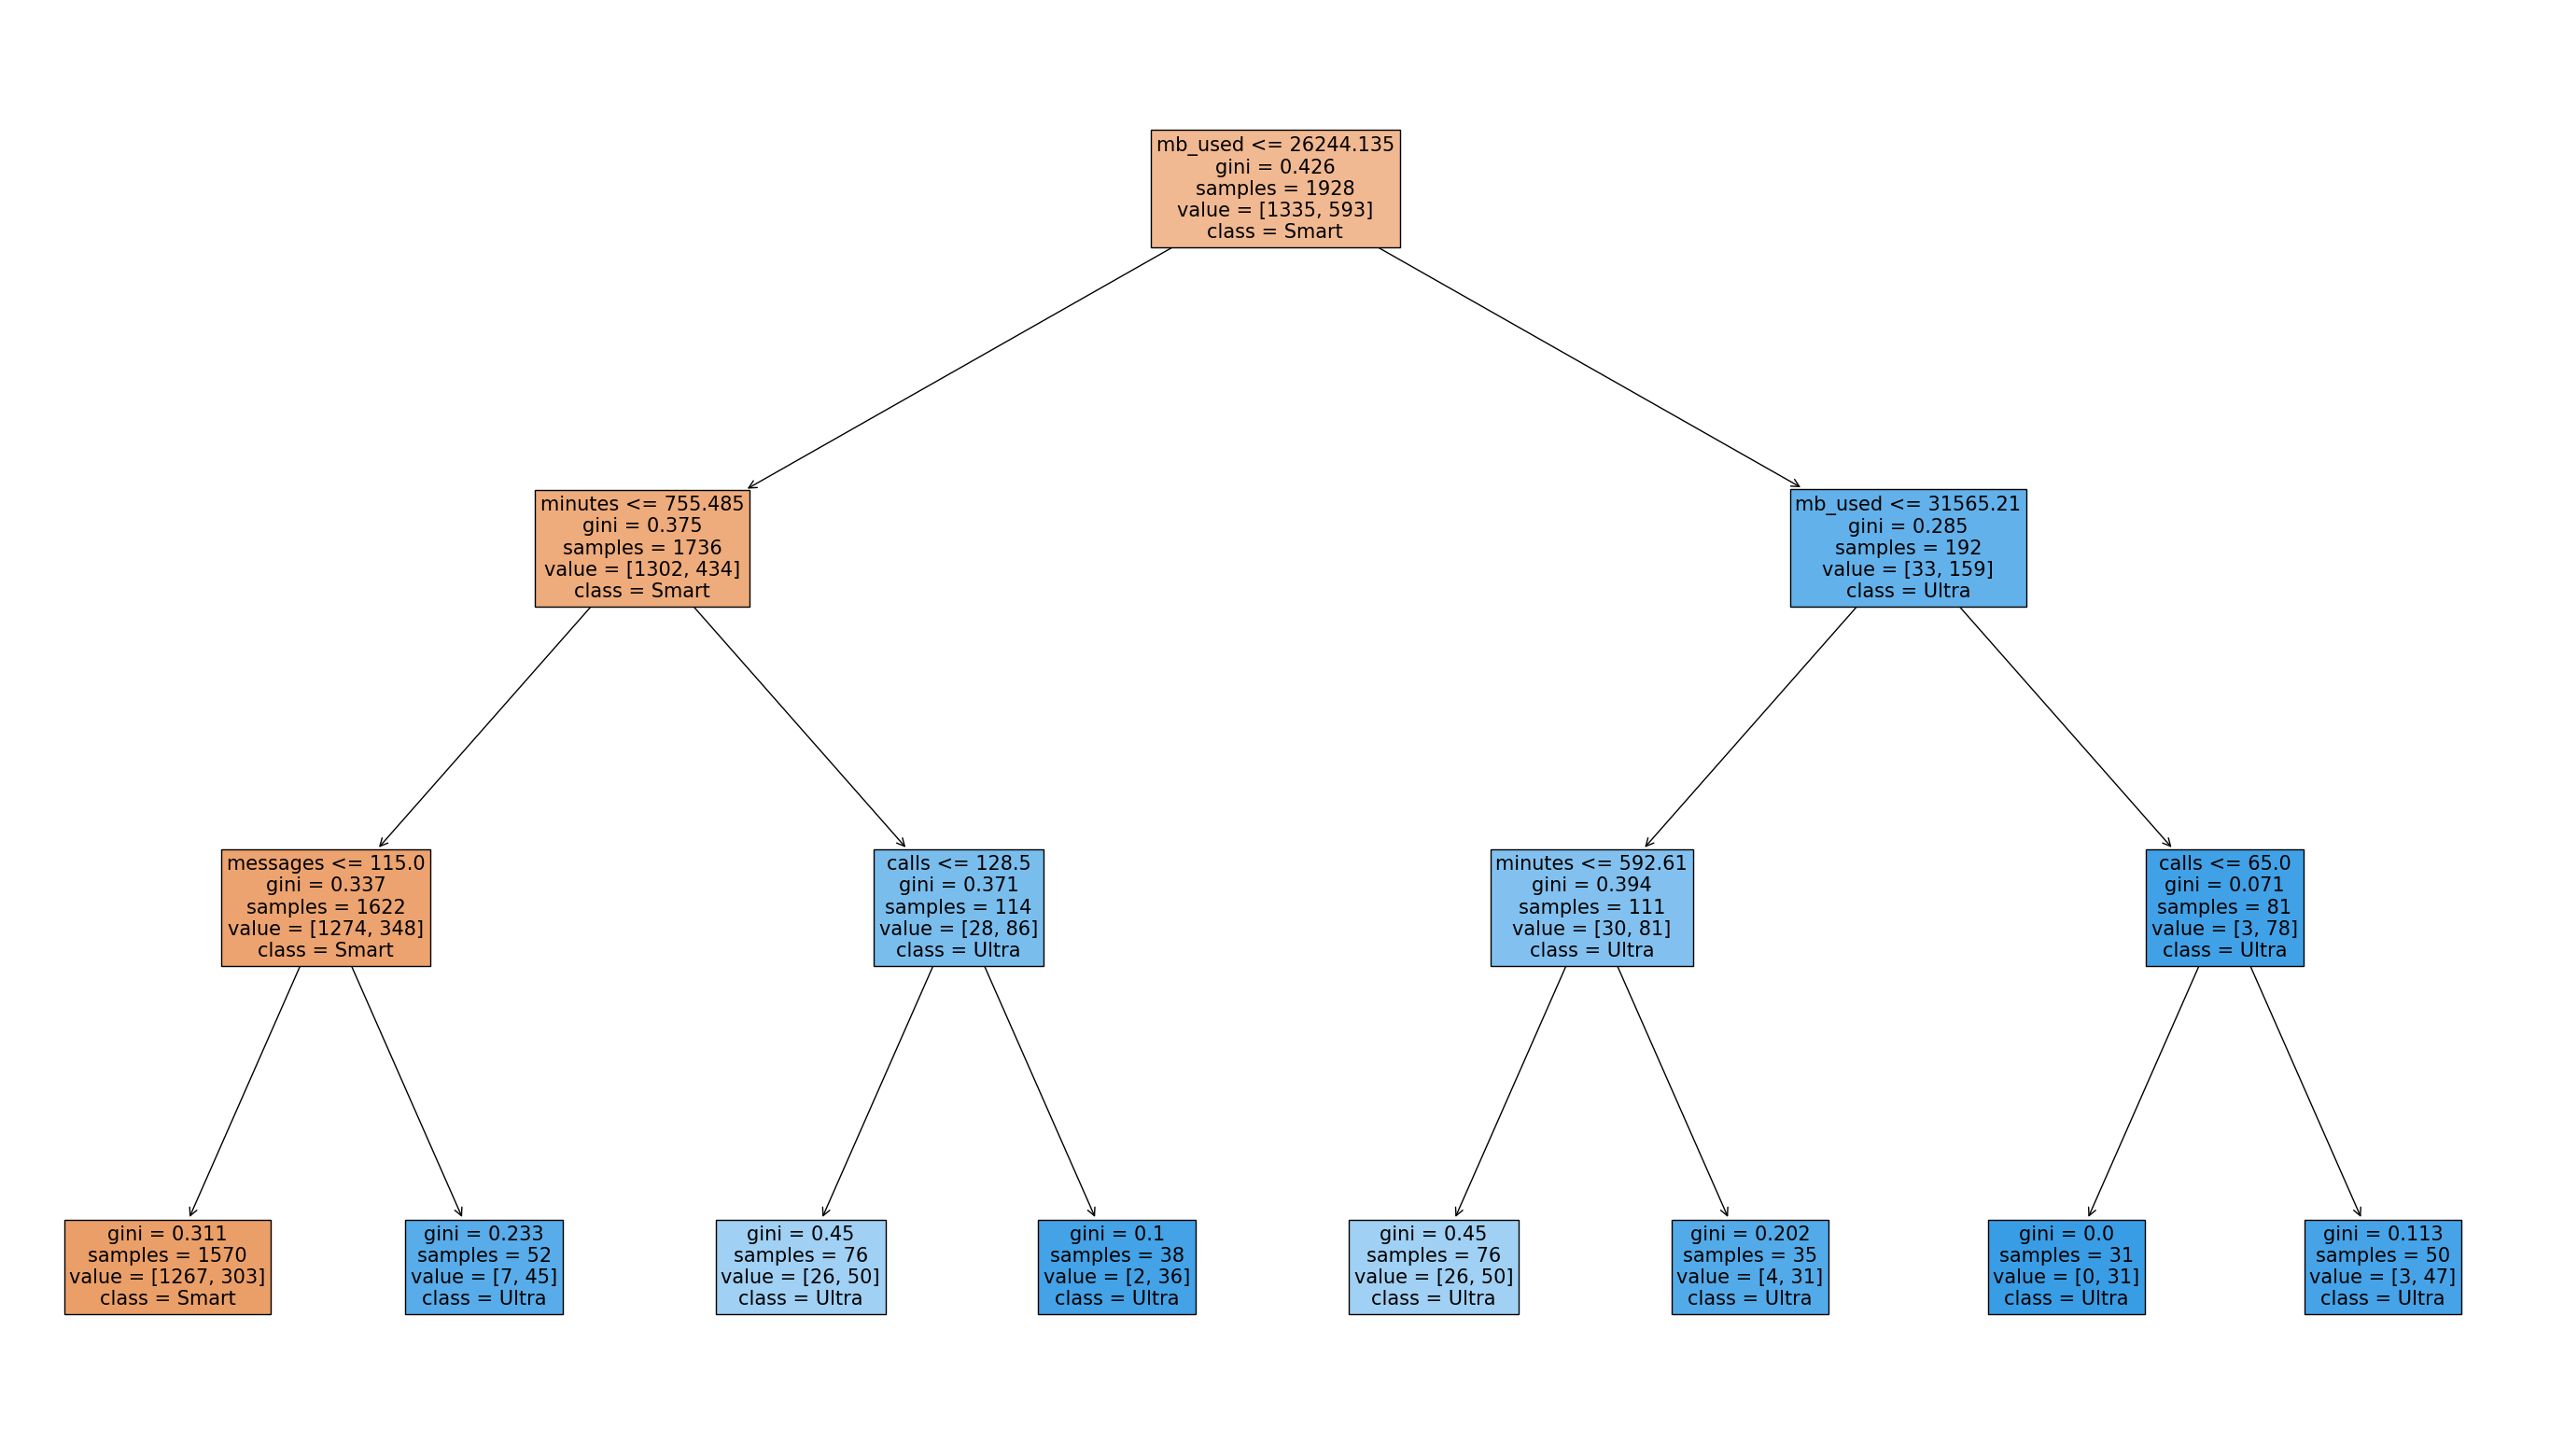

In [13]:
%%time
# Построим деревья решений для модели best_model при помощи функции plot_tree
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(best_model, 
                   feature_names=features_train.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   max_depth=3,
                   fontsize = 15)

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.5.1:**

- Модель Дерево решений выдает лучшее accuracy: 0.785 при значении гиперпараметре глубины дерева: 3
- В конце была выбрана модель с наилучшим значением accuracy на валидационной выборке
- Построен график зависимости accuracy от индекса для обучающей и валидационной выборок

## RandomForestClassifier

**ТЕОРИЯ**

**RandomForestClassifier** Классификация подойдёт к концу, когда сеть дойдёт до подмножества только с одним объектом. Если объединить несколько подобных деревьев решений, то получится так называемый Случайный Лес (англ. Random Forest). Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения.

Для данной модели есть следующие гиперпараметры:
- n_estimators (количество деревьев),
- max_depth (максимальная глубина дерева),
- min_samples_split (минимальное количество объектов в узле для разделения),
- min_samples_leaf (минимальное количество объектов в листе),
- max_features (максимальное количество признаков для разделения узла).

Best accuracy: 0.7931570762052877
Best max depth: 18
Best max estimators: 18
Best model: RandomForestClassifier(max_depth=18, n_estimators=18, random_state=12345)
Время работы модели: 1.7954070568084717


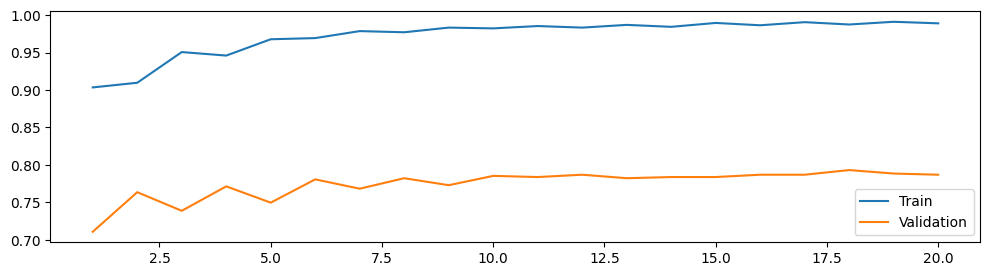

CPU times: total: 1.98 s
Wall time: 1.98 s


In [14]:
%%time
# вкл счетчик времени расчета модели
start = time.time()

# Создание списков для хранения метрик accuracy
accuracy_list_train = []
accuracy_list_valid = []
est = range(1, 21)

# Перебор значений max_depth и обучение моделей
for i in est:
    # Создание модели
    model = RandomForestClassifier(random_state=12345, n_estimators=i) 
    
    # Оценка точности на обучающей выборке
    model.fit(features_train, target_train)
    accuracy_train = model.score(features_train, target_train)
    accuracy_list_train.append(accuracy_train)
    
    # Оценка точности на валидационной выборке
    model.fit(features_train, target_train)
    accuracy_valid = model.score(features_valid, target_valid)
    accuracy_list_valid.append(accuracy_valid)

# Нахождение модели с наилучшим значением accuracy на валидационной выборке
best_index = accuracy_list_valid.index(max(accuracy_list_valid))
best_accuracy = accuracy_list_valid[best_index]
best_depth = max_depth_values[best_index]
best_est = est[best_index]
best_model_RF = RandomForestClassifier(max_depth=best_depth, random_state=12345, n_estimators=best_est)
best_model_RF.fit(features_train, target_train)

# Вывод результатов
print("Best accuracy:", best_accuracy)
print("Best max depth:", best_depth)
print("Best max estimators:", best_est)
print("Best model:", best_model_RF)

# вывод времени расчета модели
end = time.time() - start 
print('Время работы модели:', end)

# Построение графика зависимости accuracy от индекса для обучающей и валидационной выборок
plt.figure(figsize=(12, 3))
plt.plot(max_depth_values, accuracy_list_train, label="Train")
plt.plot(max_depth_values, accuracy_list_valid, label="Validation")
plt.legend()
plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.5.2:**

- Модель Случайный лес выдает лучшее accuracy: 0.793 при значении гиперпараметров: глубины дерева - 18, количество деревьев estimators - 18
- В конце была выбрана модель с наилучшим значением accuracy на валидационной выборке
- Построен график зависимости accuracy от индекса для обучающей и валидационной выборок

## LogisticRegression

**ТЕОРИЯ**

**Logistic Regression** Логистическая регрессия выводит прогнозы о точках в бинарном масштабе — нулевом или единичном. Если значение чего-либо равно либо больше 0.5, то объект классифицируется в большую сторону (к единице). Если значение меньше 0.5 — в меньшую (к нулю). У каждого признака есть своя метка, равная только 0 или только 1. Логистическая регрессия является линейным классификатором и поэтому используется, когда в данных прослеживается какая-то линейная зависимость.

Для данной модели есть следующие гиперпараметры:
- C (обратная сила регуляризации),
- penalty (тип регуляризации),
- solver (алгоритм оптимизации).

**РЕШЕНИЕ:**

In [15]:
# Простая модель Логистической регрессии:
model = LogisticRegression(solver='lbfgs')
model.fit(features_train, target_train)
accuracy = model.score(features_valid, target_valid)
print("accuracy:", accuracy)

accuracy: 0.7107309486780715


Best accuracy: 0.7107309486780715
Best iter_values: 39
Best model: LogisticRegression(max_iter=39, random_state=12345)
Время работы модели: 4.9129838943481445


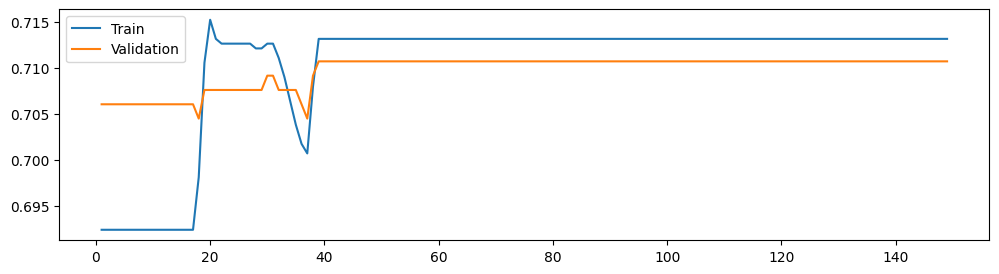

CPU times: total: 5.08 s
Wall time: 5.09 s


In [16]:
%%time
# вкл счетчик времени расчета модели
start = time.time()

import warnings
warnings.filterwarnings('ignore')

# Создание списка значений max_iter для перебора
iter_values = range(1, 150)

# Создание списков для хранения метрик accuracy
accuracy_list_train = []
accuracy_list_valid = []

# Перебор значений max_iter и обучение моделей
for iter in iter_values:
    # Создание модели
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter)
    
    # Оценка точности на обучающей выборке
    model.fit(features_train, target_train)
    accuracy_train = model.score(features_train, target_train)
    accuracy_list_train.append(accuracy_train)
    
    # Оценка точности на валидационной выборке
    model.fit(features_train, target_train)
    accuracy_valid = model.score(features_valid, target_valid)
    accuracy_list_valid.append(accuracy_valid)

# Нахождение модели с наилучшим значением accuracy на валидационной выборке
best_index = accuracy_list_valid.index(max(accuracy_list_valid))
best_accuracy = accuracy_list_valid[best_index]
best_iter_values = iter_values[best_index]
best_model = LogisticRegression(random_state=12345, max_iter=best_iter_values)
best_model.fit(features_train, target_train)

# Вывод результатов
print("Best accuracy:", best_accuracy)
print("Best iter_values:", best_iter_values)
print("Best model:", best_model)

# вывод времени расчета модели
end = time.time() - start 
print('Время работы модели:', end)

# Построение графика зависимости accuracy от индекса для обучающей и валидационной выборок
plt.figure(figsize=(12, 3))
plt.plot(iter_values, accuracy_list_train, label="Train")
plt.plot(iter_values, accuracy_list_valid, label="Validation")
plt.legend()
plt.show()


Копнем глубже и напишем код, в котором будет перебор параметров: **C** (обратная величина коэффициента регуляризации), **penalty** (тип регуляризации) и **solver** (алгоритм оптимизации) для классификации **Logistic Regression**.

Для этого выполним поиск лучших параметров с помощью **GridSearchCV** (инструмент для автоматического подбирания параметров для моделей машинного обучения). Он перебирает все возможные комбинации заданных параметров модели, обучает модель на каждой комбинации и вычисляет метрику качества (accuracy) на обучающей выборке с помощью кросс-валидации. В итоге выбирем лучшую комбинацию параметров, у которой достигается наилучшее значение **accuracy**.

Выведем лучшее значение **accuracy** и параметры модели, при которых оно достигается.

Далее создадим графики зависимости **accuracy** от параметров **C, penalty и solver**. Для этого обучим модель на каждой комбинации параметров и вычислим метрику качества на валидационной выборке. Затем построим графики, на которых по оси **X** отмечены значения параметров **penalty** и **solver**, а по оси **Y** - **accuracy**. Каждый график соответствует определенному значению параметра **C**. Таким образом, можно оценить, как значение **accuracy** меняется в зависимости от значений других параметров при фиксированном значении **C**.

Best accuracy: 0.7489670950810847
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


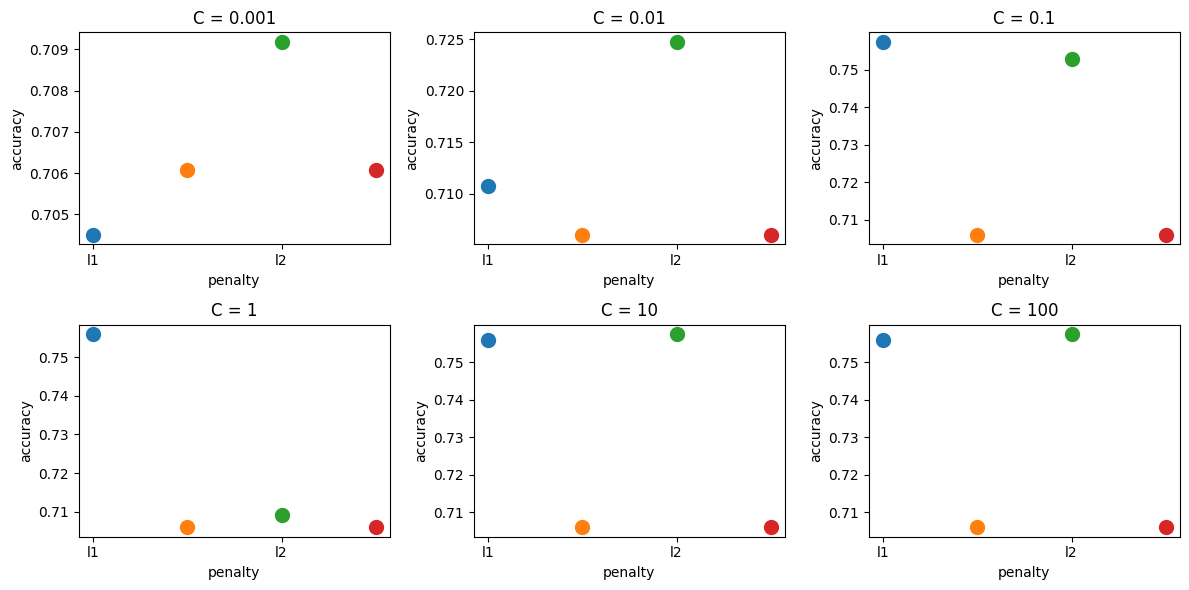

CPU times: total: 1.81 s
Wall time: 1.8 s


In [17]:
%%time

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']}

# Создание модели Logistic Regression
log_reg = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=10)

# Поиск лучших параметров с помощью GridSearchCV
grid_search = GridSearchCV(log_reg, parameters, cv=5, scoring='accuracy')
grid_search.fit(features_train, target_train)

# Вывод лучшего accuracy и параметров модели для него
print('Best accuracy:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

# Графики зависимости accuracy от других параметров
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
penalty_values = ['l1', 'l2']
solver_values = ['liblinear', 'saga']

accuracy_scores = np.zeros((len(C_values), len(penalty_values), len(solver_values)))

for i in range(len(C_values)):
    for j in range(len(penalty_values)):
        for k in range(len(solver_values)):
            log_reg = LogisticRegression(C=C_values[i], penalty=penalty_values[j], solver=solver_values[k])
            log_reg.fit(features_train, target_train)
            accuracy_scores[i, j, k] = log_reg.score(features_valid, target_valid)

plt.figure(figsize=(12, 6))

for i in range(len(C_values)):
    plt.subplot(2, 3, i + 1)
    for j in range(len(penalty_values)):
        for k in range(len(solver_values)):
            plt.plot([j + k / 2.0], [accuracy_scores[i, j, k]], 'o', markersize=10)
    plt.title('C = ' + str(C_values[i]))
    plt.xticks([0, 1], penalty_values)
    plt.xlabel('penalty')
    plt.ylabel('accuracy')

plt.tight_layout()
plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.5.3:**

- На графике зависимости accuracy от индекса для обучающей и валидационной выборок видно, что достачно 40 итераций, далее зависимость не меняется
- На втором графике с перебором параметров можно выбрать оптимальный набор их для модели. Например, если мы хотим получить модель с максимальной точностью при значении параметра C=1, то на графике с C=1 нужно выбрать значение penalty и solver, при которых достигается наивысшее значение accuracy.

# Проверка моделей на тестовой выборке

## RandomForestClassifier

In [18]:
model = RandomForestClassifier(n_estimators=18, random_state=12345)
model.fit(features_train, target_train)
accuracy = model.score(features_test, target_test)
print("Точность:", accuracy)

Точность: 0.7853810264385692


In [19]:
# прогноз на тестовой выборке для лучшей модели RandomForestClassifier
pred_random_forest_test = best_model_RF.predict(features_test)

# точность прогноза лучшей модели случайного леса
accuracy_score(target_test, pred_random_forest_test)

# метрика f1 для лучшей модели случайного леса
f1_score(target_test, pred_random_forest_test)

# подсчет выборок
features_train.shape, target_train.shape
features_valid.shape, target_valid.shape

# обучим модель на объединенной выборке train+valid
features_train_valid = pd.concat((features_train, features_valid), axis=0)
target_train_valid = pd.concat((target_train, target_valid), axis=0)

# подсчет выборки
features_train_valid.shape, target_train_valid.shape

# модель с лучшими параметрами
model_random_forest = RandomForestClassifier(random_state=12345, max_depth = 18, n_estimators = 18)

# обучим модель
model_random_forest.fit(features_train_valid, target_train_valid)

# прогноз
pred_random_forest_test = \
model_random_forest.predict(features_test)

# точность
result = accuracy_score(target_test, pred_random_forest_test)
f1 = f1_score(target_test, pred_random_forest_test)

# результат
print('accuracy_score: ', result)
print('f1: ', f1)

accuracy_score:  0.7916018662519441
f1:  0.6318681318681318


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.6:**
    
- Исходя из точности разных моделей классификаций наиболее предпочтительна - Случайный лес
- accuracy_score:  0.7916018662519441
- f1:  0.6318681318681318
    

# Проверка модели на адекватность

**ТЕОРИЯ**

Ошибка объекта показывает, как сильно правильный ответ отличается от предсказания. Если ошибка намного больше нуля, модель  переоценена; меньше — недооценена. Возведение в квадрат убирает разницу между переоценкой и недооценкой. Без этого шага нет смысла суммировать ошибки: положительные будут компенсировать отрицательные. Усреднение нужно, чтобы получить данные по всем объектам. В предыдущих моделях добивались наибольшего значения **accuracy**. Величина **MSE**, наоборот, должна быть как можно меньше.

Чтобы оценить адекватность модели в задачах классификации, нужно сравнить её со случайной. 

Инициализируем модель линейной регрессии, обучим её. Посчитайте значение метрики **RMSE** на валидационной выборке и сохраните в переменной **result**

In [20]:
# инициализируем модель LinearRegression
model = LinearRegression() 

# обучим модель на тренировочной выборке
model.fit(features_train, target_train) 

# получим предсказания модели на валидационной выборке
predictions_valid = model.predict(features_valid) 

# посчим значение метрики RMSE на валидационной выборке
result = mean_squared_error(target_test, predictions_valid)**0.5  

print("RMSE модели линейной регрессии на валидационной выборке:", result)


RMSE модели линейной регрессии на валидационной выборке: 0.48472173604556207


In [21]:
# Проверим модели на вменяемость
# Создадим модель model_dummy
model_dummy = DummyClassifier(strategy='most_frequent', random_state=12345)

# обучение модели model_dummy на тренировочной выборке
model_dummy.fit(features_train, target_train)
model_dummy.predict(features_test)

# качество модели на тестовой выборке
accuracy_dummy = model_dummy.score(features_test, target_test) 
print(f'Прогноз самого частого класса ("0"): {accuracy_dummy:.1%}')

Прогноз самого частого класса ("0"): 68.4%


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.7:**
    
- RMSE модели линейной регрессии на валидационной выборке: 0.48472173604556207
- Прогноз самого частого класса ("0"): 68.4%

# Общий вывод

<div style='border:solid violet 5px; padding: 20px'>

**Краткий обзор проделанной работы**

**1. Изучены входные данные**
- импортированы все необходимые библиотеки и модули
- приведена общая информация о датафрейме
- построена общая гистограмма для всех числовых столбцов датафрейма
- В двух колонках (сalls — количество звонков и messages — количество sms-сообщений) заменен тип данных на тип int
- Выведены основные статистические данные датафрейма

**2. Приведены теоретическая часть по исследуемым моделям**

**3. Подготовка данных** включала в себя разбивка датафрейма на обучающую, валидационную и тестовую. Исходные данные разбили в соотношении 3:1:1.


**4. Исследование моделей**
1. DecisionTreeClassifier:
    - Модель Дерево решений выдает лучшее accuracy: 0.785 при значении гиперпараметре глубины дерева: 3
    - В конце была выбрана модель с наилучшим значением accuracy на валидационной выборке
    - Построен график зависимости accuracy от индекса для обучающей и валидационной выборок


2. RandomForestClassifier
    - Модель Дерево решений выдает лучшее accuracy: 0.793 при значении гиперпараметре глубины дерева: 18
    - В конце была выбрана модель с наилучшим значением accuracy на валидационной выборке
    - Построен график зависимости accuracy от индекса для обучающей и валидационной выборок

3.  LogisticRegression
    - На графике зависимости accuracy от индекса для обучающей и валидационной выборок видно, что достачно 40 итераций, далее зависимость не меняется
    - На втором графике с перебором параметров можно выбрать оптимальный набор их для модели. Например, если мы хотим получить модель с максимальной точностью при значении параметра C=1, то на графике с C=1 нужно выбрать значение penalty и solver, при которых достигается наивысшее значение accuracy.

**5. Проверка моделей на тестовой выборке**
    
- Исходя из точности разных моделей классификаций наиболее предпочтительна - Случайный лес
- accuracy_score:  0.7916018662519441
- f1:  0.6318681318681318


**6. Проверка модели на адекватность**
    
- RMSE модели линейной регрессии на валидационной выборке: 0.48472173604556207
- Прогноз самого частого класса ("0"): 68.4%